In [1]:
import xarray as xr
import numpy as np
import warnings
from tqdm import tqdm, tqdm_notebook
warnings.simplefilter('ignore', xr.SerializationWarning)
xr.__version__

'0.11.3'

In [13]:
from time import sleep
with tqdm_notebook(total=20) as pbar:
    for n in range(5):
        pbar.total=5
        sleep(0.2)
        pbar.update()
    pbar.close()
        

In [2]:
#!/usr/bin/env python
from __future__ import print_function
import requests
import numpy
import pandas as pd
from collections import OrderedDict

# API AT: https://github.com/ESGF/esgf.github.io/wiki/ESGF_Search_REST_API#results-pagination

def check_doc_for_malformed_id(d):
    source_id = d['source_id'][0]
    expt_id = d['experiment_id'][0]
    if not  f"{source_id}_{expt_id}" in d['id']:
        raise ValueError(f"Dataset id {d['id']} is malformed")
                         
def maybe_squeze_values(d):
    def _maybe_squeeze(value):
        if isinstance(value, str):
            return value
        try:
            if len(value)==1:
                return value[0]
        except TypeError:
            return(value)
    return {k: _maybe_squeeze(v) for k, v in d.items()}
                         
def get_request(client, server, **payload):
    url_keys = [] 
    url_keys = ["{}={}".format(k, payload[k]) for k in payload]
    url = "{}/?{}".format(server, "&".join(url_keys))
    r = client.get(url)
    r.raise_for_status()
    resp = r.json()["response"]
    return resp

def esgf_search(server="https://esgf-node.llnl.gov/esg-search/search",
                files_type="OPENDAP", local_node=True, project="CMIP6",
                verbose=False, format="application%2Fsolr%2Bjson",
                use_csrf=False, **search):
    client = requests.session()
                         
    payload = search
    payload["project"] = project
    payload["type"]= "File"
    if local_node:
        payload["distrib"] = "false"
    if use_csrf:
        client.get(server)
        if 'csrftoken' in client.cookies:
            # Django 1.6 and up
            csrftoken = client.cookies['csrftoken']
        else:
            # older versions
            csrftoken = client.cookies['csrf']
        payload["csrfmiddlewaretoken"] = csrftoken

    payload["format"] = format

    offset = 0
    numFound = 10000
    all_files = []
    files_type = files_type.upper()
                         
    while offset < numFound:
        resp = get_request(client, server, offset=offset, **payload)
        resp = r.json()["response"]
        numFound = int(resp["numFound"])
        docs = resp["docs"]
        offset += len(docs)

        for d in docs:
            try:
                check_doc_for_malformed_id(d)
            except ValueError:
                continue
            dataset_id = d['dataset_id']
            item = OrderedDict(dataset_id=dataset_id, id=d['id'])
            #item.update({field: d[field][0] for field in required_fields})
            target_urls = d.pop('url')
            item.update(maybe_squeze_values(d))
            for f in target_urls:
                sp = f.split("|")
                if sp[-1] == files_type:
                    opendap_url = sp[0].replace('.html', '')
                    item.update({f'{files_type}_url': opendap_url})
                    all_files.append(item)
    return pd.DataFrame(all_files)

In [6]:
#files = esgf_search(variable="tas", experiment_id="historical", frequency="mon")
#files = esgf_search(variable="ta", frequency="mon", activity_drs='CMIP', table_id='Amon', experiment_id='historical')
files = esgf_search()
files

https://esgf-node.llnl.gov/esg-search/search/?project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=0
https://esgf-node.llnl.gov/esg-search/search/?project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=10
https://esgf-node.llnl.gov/esg-search/search/?project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=20
https://esgf-node.llnl.gov/esg-search/search/?project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=30
https://esgf-node.llnl.gov/esg-search/search/?project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=40
https://esgf-node.llnl.gov/esg-search/search/?project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=50
https://esgf-node.llnl.gov/esg-search/search/?project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=60
https://esgf-node.llnl.gov/esg-search/search/?project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2B

KeyboardInterrupt: 

In [4]:
for k, v in files.groupby('dataset_id'):
    print(k)

CMIP6.CMIP.BCC.BCC-CSM2-MR.historical.r1i1p1f1.Amon.ta.gn.v20181126|cmip.bcc.cma.cn
CMIP6.CMIP.BCC.BCC-CSM2-MR.historical.r2i1p1f1.Amon.ta.gn.v20181115|cmip.bcc.cma.cn
CMIP6.CMIP.BCC.BCC-CSM2-MR.historical.r3i1p1f1.Amon.ta.gn.v20181119|cmip.bcc.cma.cn
CMIP6.CMIP.BCC.BCC-ESM1.historical.r1i1p1f1.Amon.ta.gn.v20181217|cmip.bcc.cma.cn
CMIP6.CMIP.BCC.BCC-ESM1.historical.r2i1p1f1.Amon.ta.gn.v20181217|cmip.bcc.cma.cn
CMIP6.CMIP.BCC.BCC-ESM1.historical.r3i1p1f1.Amon.ta.gn.v20181217|cmip.bcc.cma.cn
CMIP6.CMIP.CNRM-CERFACS.CNRM-CM6-1.historical.r1i1p1f2.Amon.ta.gr.v20180917|aims3.llnl.gov
CMIP6.CMIP.CNRM-CERFACS.CNRM-CM6-1.historical.r2i1p1f2.Amon.ta.gr.v20181126|aims3.llnl.gov
CMIP6.CMIP.IPSL.IPSL-CM6A-LR.historical.r10i1p1f1.Amon.ta.gr.v20180803|aims3.llnl.gov
CMIP6.CMIP.IPSL.IPSL-CM6A-LR.historical.r11i1p1f1.Amon.ta.gr.v20180803|aims3.llnl.gov
CMIP6.CMIP.IPSL.IPSL-CM6A-LR.historical.r12i1p1f1.Amon.ta.gr.v20180803|aims3.llnl.gov
CMIP6.CMIP.IPSL.IPSL-CM6A-LR.historical.r13i1p1f1.Amon.ta.gr.v201

In [403]:
files.experiment_id.unique()

array(['1pctCO2', 'esm-hist', 'esm-piControl', 'historical', 'piControl',
       'abrupt-4xCO2', 'amip', 'esm-piControl-spinup', 'piControl-spinup'],
      dtype=object)

In [5]:
# standard hierarchy
required_fields = ['mip_era', 'activity_drs', 'institution_id', 'source_id', 'experiment_id',
                   'member_id', 'table_id', 'variable_id', 'grid_label']
for k, v in files.groupby(required_fields):
    print(k)

('CMIP6', 'CMIP', 'BCC', 'BCC-CSM2-MR', 'historical', 'r1i1p1f1', 'Amon', 'ta', 'gn')
('CMIP6', 'CMIP', 'BCC', 'BCC-CSM2-MR', 'historical', 'r2i1p1f1', 'Amon', 'ta', 'gn')
('CMIP6', 'CMIP', 'BCC', 'BCC-CSM2-MR', 'historical', 'r3i1p1f1', 'Amon', 'ta', 'gn')
('CMIP6', 'CMIP', 'BCC', 'BCC-ESM1', 'historical', 'r1i1p1f1', 'Amon', 'ta', 'gn')
('CMIP6', 'CMIP', 'BCC', 'BCC-ESM1', 'historical', 'r2i1p1f1', 'Amon', 'ta', 'gn')
('CMIP6', 'CMIP', 'BCC', 'BCC-ESM1', 'historical', 'r3i1p1f1', 'Amon', 'ta', 'gn')
('CMIP6', 'CMIP', 'CNRM-CERFACS', 'CNRM-CM6-1', 'historical', 'r1i1p1f2', 'Amon', 'ta', 'gr')
('CMIP6', 'CMIP', 'CNRM-CERFACS', 'CNRM-CM6-1', 'historical', 'r2i1p1f2', 'Amon', 'ta', 'gr')
('CMIP6', 'CMIP', 'IPSL', 'IPSL-CM6A-LR', 'historical', 'r10i1p1f1', 'Amon', 'ta', 'gr')
('CMIP6', 'CMIP', 'IPSL', 'IPSL-CM6A-LR', 'historical', 'r11i1p1f1', 'Amon', 'ta', 'gr')
('CMIP6', 'CMIP', 'IPSL', 'IPSL-CM6A-LR', 'historical', 'r12i1p1f1', 'Amon', 'ta', 'gr')
('CMIP6', 'CMIP', 'IPSL', 'IPSL-CM6A-L

In [383]:
def recursive_groupby(df, by):
    if isinstance(by, str):
        for k, v in df.groupby(by):
            yield k, v

for k, v in recursive_groupby(files, 'mip_era'):
    print(k)

CMIP6


In [389]:
for k0, v0 in files.groupby(required_fields[0]):
    print(len(v))
    for k1, v1 in v0.groupby(required_fields[1]):
        print(len(v1))
        for k2, v2 in v1.groupby(required_fields[2]):
            print(len(v2))
            print(dict(zip(required_fields[:3], [k0, k1, k2])))

153
153
9
{'mip_era': 'CMIP6', 'activity_drs': 'CMIP', 'institution_id': 'BCC'}
19
{'mip_era': 'CMIP6', 'activity_drs': 'CMIP', 'institution_id': 'CNRM-CERFACS'}
7
{'mip_era': 'CMIP6', 'activity_drs': 'CMIP', 'institution_id': 'IPSL'}
84
{'mip_era': 'CMIP6', 'activity_drs': 'CMIP', 'institution_id': 'MIROC'}
34
{'mip_era': 'CMIP6', 'activity_drs': 'CMIP', 'institution_id': 'NASA-GISS'}


In [385]:
v2

,dataset_id,id,version,activity_drs,activity_id,branch_method,cf_standard_name,checksum,checksum_type,citation_url,...,variable,variable_id,variable_long_name,variable_units,variant_label,_version_,retracted,_timestamp,score,OPENDAP_url
119,CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.1pctCO2.r1i1p...,CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.1pctCO2.r1i1p...,1,CMIP,CMIP,standard,air_temperature,dc83b52e9b5f1087bbde4c69cd05590603bf311e4fa61a...,SHA256,http://cera-www.dkrz.de/WDCC/meta/CMIP6/CMIP6....,...,tas,tas,Near-Surface Air Temperature,K,r1i1p1f1,1623059987626459136,False,2019-01-19T04:03:44.186Z,1.0,http://aims3.llnl.gov/thredds/dodsC/css03_data...
120,CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.1pctCO2.r1i1p...,CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.1pctCO2.r1i1p...,1,CMIP,CMIP,standard,air_temperature,4711be106b584d2022c8f04e395de3925891cbbce13120...,SHA256,http://cera-www.dkrz.de/WDCC/meta/CMIP6/CMIP6....,...,tas,tas,Near-Surface Air Temperature,K,r1i1p1f1,1623059987597099008,False,2019-01-19T04:03:44.158Z,1.0,http://aims3.llnl.gov/thredds/dodsC/css03_data...
121,CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.1pctCO2.r1i1p...,CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.1pctCO2.r1i1p...,1,CMIP,CMIP,standard,air_temperature,43203f990b71357c35c417752f6f7cbb01713e790a9887...,SHA256,http://cera-www.dkrz.de/WDCC/meta/CMIP6/CMIP6....,...,tas,tas,Near-Surface Air Temperature,K,r1i1p1f1,1623059987567738880,False,2019-01-19T04:03:44.130Z,1.0,http://aims3.llnl.gov/thredds/dodsC/css03_data...
122,CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.abrupt-4xCO2....,CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.abrupt-4xCO2....,1,CMIP,CMIP,standard,air_temperature,f17a9fa4ba702689adae96233bf5512bbd6e65a1f5c45d...,SHA256,http://cera-www.dkrz.de/WDCC/meta/CMIP6/CMIP6....,...,tas,tas,Near-Surface Air Temperature,K,r1i1p1f1,1623060827810562048,False,2019-01-19T04:17:05.448Z,1.0,http://aims3.llnl.gov/thredds/dodsC/css03_data...
123,CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.abrupt-4xCO2....,CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.abrupt-4xCO2....,1,CMIP,CMIP,standard,air_temperature,3d977fc292951a137426665818435cfae0c76ec15fd2db...,SHA256,http://cera-www.dkrz.de/WDCC/meta/CMIP6/CMIP6....,...,tas,tas,Near-Surface Air Temperature,K,r1i1p1f1,1623060827783299072,False,2019-01-19T04:17:05.422Z,1.0,http://aims3.llnl.gov/thredds/dodsC/css03_data...
124,CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.abrupt-4xCO2....,CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.abrupt-4xCO2....,1,CMIP,CMIP,standard,air_temperature,eef0b936361a2b37765871fe9e051cd9c2776c1516b578...,SHA256,http://cera-www.dkrz.de/WDCC/meta/CMIP6/CMIP6....,...,tas,tas,Near-Surface Air Temperature,K,r1i1p1f1,1623060827754987520,False,2019-01-19T04:17:05.395Z,1.0,http://aims3.llnl.gov/thredds/dodsC/css03_data...
125,CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.amip.r1i1p1f1...,CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.amip.r1i1p1f1...,1,CMIP,CMIP,standard,air_temperature,b71980be0c790d242788702fb33187af4618d093c2718c...,SHA256,http://cera-www.dkrz.de/WDCC/meta/CMIP6/CMIP6....,...,tas,tas,Near-Surface Air Temperature,K,r1i1p1f1,1623072931392258048,False,2019-01-19T07:29:28.323Z,1.0,http://aims3.llnl.gov/thredds/dodsC/css03_data...
126,CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.amip.r1i1p1f1...,CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.amip.r1i1p1f1...,1,CMIP,CMIP,standard,air_temperature,6f33061de83e740b3db96caaef67c0b2b6ac25249e7e77...,SHA256,http://cera-www.dkrz.de/WDCC/meta/CMIP6/CMIP6....,...,tas,tas,Near-Surface Air Temperature,K,r1i1p1f1,1623072931364995072,False,2019-01-19T07:29:28.297Z,1.0,http://aims3.llnl.gov/thredds/dodsC/css03_data...
127,CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.amip.r1i1p1f1...,CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.amip.r1i1p1f1...,1,CMIP,CMIP,standard,air_temperature,35425874c951574b5f815a19b1924f6f254b03d30831fd...,SHA256,http://cera-www.dkrz.de/WDCC/meta/CMIP6/CMIP6....,...,tas,tas,Near-Surface Air Temperature,K,r1i1p1f1,1623072931336683520,False,2019-01-19T07:29:28.270Z,1.0,http://aims3.llnl.gov/thredds/dodsC/css03_data...
128,CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.amip.r1i1p1f1...,CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.amip.r1i1p1f1...,1,CMIP,CMIP,st

In [317]:
variable = files['variable']
data_node = files['data_node'] 

In [323]:
isinstance(variable, str)

False

In [309]:
vd = v.drop('url', axis=1)
vd

,dataset_id,id,mip_era,activity_drs,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label
149,CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.historical.r1...,CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.historical.r1...,CMIP6,CMIP,NASA-GISS,GISS-E2-1-G,historical,r1i1p1f1,Amon,tas,gn
150,CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.historical.r1...,CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.historical.r1...,CMIP6,CMIP,NASA-GISS,GISS-E2-1-G,historical,r1i1p1f1,Amon,tas,gn
151,CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.historical.r1...,CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.historical.r1...,CMIP6,CMIP,NASA-GISS,GISS-E2-1-G,historical,r1i1p1f1,Amon,tas,gn
152,CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.historical.r1...,CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.historical.r1...,CMIP6,CMIP,NASA-GISS,GISS-E2-1-G,historical,r1i1p1f1,Amon,tas,gn


In [406]:
for k, v in files.groupby('dataset_id'):
    print(k)

CMIP6.CMIP.BCC.BCC-CSM2-MR.historical.r1i1p1f1.Amon.ta.gn.v20181126|cmip.bcc.cma.cn
CMIP6.CMIP.BCC.BCC-CSM2-MR.historical.r2i1p1f1.Amon.ta.gn.v20181115|cmip.bcc.cma.cn
CMIP6.CMIP.BCC.BCC-CSM2-MR.historical.r3i1p1f1.Amon.ta.gn.v20181119|cmip.bcc.cma.cn
CMIP6.CMIP.CNRM-CERFACS.CNRM-CM6-1.historical.r1i1p1f2.AERmonZ.ta.grz.v20180917|aims3.llnl.gov
CMIP6.CMIP.CNRM-CERFACS.CNRM-CM6-1.historical.r1i1p1f2.Amon.ta.gr.v20180917|aims3.llnl.gov
CMIP6.CMIP.CNRM-CERFACS.CNRM-CM6-1.historical.r1i1p1f2.CFmon.ta.gr.v20180917|aims3.llnl.gov
CMIP6.CMIP.CNRM-CERFACS.CNRM-CM6-1.historical.r2i1p1f2.AERmonZ.ta.grz.v20181126|aims3.llnl.gov
CMIP6.CMIP.CNRM-CERFACS.CNRM-CM6-1.historical.r2i1p1f2.Amon.ta.gr.v20181126|aims3.llnl.gov
CMIP6.CMIP.CNRM-CERFACS.CNRM-CM6-1.historical.r2i1p1f2.CFmon.ta.gr.v20181126|aims3.llnl.gov
CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.historical.r10i1p1f1.Amon.ta.gn.v20180830|aims3.llnl.gov
CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.historical.r1i1p1f1.Amon.ta.gn.v20180827|aims3.llnl.gov


,dataset_id,id,version,activity_drs,activity_id,branch_method,cf_standard_name,checksum,checksum_type,citation_url,...,variable,variable_id,variable_long_name,variable_units,variant_label,_version_,retracted,_timestamp,score,url
149,CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.historical.r1...,CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.historical.r1...,1,CMIP,CMIP,standard,air_temperature,040fcbcc7beb2a149413d434ea8d0d55280d2d274f0a64...,SHA256,http://cera-www.dkrz.de/WDCC/meta/CMIP6/CMIP6....,...,tas,tas,Near-Surface Air Temperature,K,r1i1p1f1,1623085480053571584,False,2019-01-19T10:48:55.659Z,1.0,http://aims3.llnl.gov/thredds/dodsC/css03_data...
150,CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.historical.r1...,CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.historical.r1...,1,CMIP,CMIP,standard,air_temperature,787f3551c8f1dbb4fccfc46361bed7b11f64f5f38ffcb8...,SHA256,http://cera-www.dkrz.de/WDCC/meta/CMIP6/CMIP6....,...,tas,tas,Near-Surface Air Temperature,K,r1i1p1f1,1623085480007434240,False,2019-01-19T10:48:55.615Z,1.0,http://aims3.llnl.gov/thredds/dodsC/css03_data...
151,CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.historical.r1...,CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.historical.r1...,1,CMIP,CMIP,standard,air_temperature,0bf8732e197e8061152030de3327c74d5a204be3b4054c...,SHA256,http://cera-www.dkrz.de/WDCC/meta/CMIP6/CMIP6....,...,tas,tas,Near-Surface Air Temperature,K,r1i1p1f1,1623085479982268416,False,2019-01-19T10:48:55.590Z,1.0,http://aims3.llnl.gov/thredds/dodsC/css03_data...
152,CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.historical.r1...,CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.historical.r1...,1,CMIP,CMIP,standard,air_temperature,aee8a941fbbc2e138287ac7f8276d82d0a65136e11371a...,SHA256,http://cera-www.dkrz.de/WDCC/meta/CMIP6/CMIP6....,...,tas,tas,Near-Surface Air Temperature,K,r1i1p1f1,1623085479925645312,False,2019-01-19T10:48:55.537Z,1.0,http://aims3.llnl.gov/thredds/dodsC/css03_data...


In [345]:
set(v.columns)

{'_timestamp',
 '_version_',
 'activity_drs',
 'activity_id',
 'branch_method',
 'cf_standard_name',
 'checksum',
 'checksum_type',
 'citation_url',
 'data_node',
 'data_specs_version',
 'dataset_id',
 'dataset_id_template_',
 'directory_format_template_',
 'experiment_id',
 'experiment_title',
 'frequency',
 'further_info_url',
 'grid',
 'grid_label',
 'id',
 'index_node',
 'instance_id',
 'institution_id',
 'latest',
 'master_id',
 'member_id',
 'mip_era',
 'model_cohort',
 'nominal_resolution',
 'pid',
 'product',
 'project',
 'realm',
 'replica',
 'retracted',
 'score',
 'size',
 'source_id',
 'source_type',
 'sub_experiment_id',
 'table_id',
 'timestamp',
 'title',
 'tracking_id',
 'type',
 'url',
 'variable',
 'variable_id',
 'variable_long_name',
 'variable_units',
 'variant_label',
 'version'}

In [346]:
non_duplicate_columns = {'checksum', 'id'}
all_columns = set(v.columns)
subset = all_columns - non_duplicate_columns
v.drop_duplicates(subset=subset)

,dataset_id,id,version,activity_drs,activity_id,branch_method,cf_standard_name,checksum,checksum_type,citation_url,...,variable,variable_id,variable_long_name,variable_units,variant_label,_version_,retracted,_timestamp,score,url
149,CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.historical.r1...,CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.historical.r1...,1,CMIP,CMIP,standard,air_temperature,040fcbcc7beb2a149413d434ea8d0d55280d2d274f0a64...,SHA256,http://cera-www.dkrz.de/WDCC/meta/CMIP6/CMIP6....,...,tas,tas,Near-Surface Air Temperature,K,r1i1p1f1,1623085480053571584,False,2019-01-19T10:48:55.659Z,1.0,http://aims3.llnl.gov/thredds/dodsC/css03_data...
150,CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.historical.r1...,CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.historical.r1...,1,CMIP,CMIP,standard,air_temperature,787f3551c8f1dbb4fccfc46361bed7b11f64f5f38ffcb8...,SHA256,http://cera-www.dkrz.de/WDCC/meta/CMIP6/CMIP6....,...,tas,tas,Near-Surface Air Temperature,K,r1i1p1f1,1623085480007434240,False,2019-01-19T10:48:55.615Z,1.0,http://aims3.llnl.gov/thredds/dodsC/css03_data...
151,CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.historical.r1...,CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.historical.r1...,1,CMIP,CMIP,standard,air_temperature,0bf8732e197e8061152030de3327c74d5a204be3b4054c...,SHA256,http://cera-www.dkrz.de/WDCC/meta/CMIP6/CMIP6....,...,tas,tas,Near-Surface Air Temperature,K,r1i1p1f1,1623085479982268416,False,2019-01-19T10:48:55.590Z,1.0,http://aims3.llnl.gov/thredds/dodsC/css03_data...
152,CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.historical.r1...,CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.historical.r1...,1,CMIP,CMIP,standard,air_temperature,aee8a941fbbc2e138287ac7f8276d82d0a65136e11371a...,SHA256,http://cera-www.dkrz.de/WDCC/meta/CMIP6/CMIP6....,...,tas,tas,Near-Surface Air Temperature,K,r1i1p1f1,1623085479925645312,False,2019-01-19T10:48:55.537Z,1.0,http://aims3.llnl.gov/thredds/dodsC/css03_data...


In [366]:
dict(v[v.columns[v.nunique() == 1]].iloc[0])

{'dataset_id': 'CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.historical.r1i1p1f1.Amon.tas.gn.v20180827|aims3.llnl.gov',
 'version': '1',
 'activity_drs': 'CMIP',
 'activity_id': 'CMIP',
 'branch_method': 'standard',
 'cf_standard_name': 'air_temperature',
 'checksum_type': 'SHA256',
 'citation_url': 'http://cera-www.dkrz.de/WDCC/meta/CMIP6/CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.historical.r1i1p1f1.Amon.tas.gn.v20180827.json',
 'data_node': 'aims3.llnl.gov',
 'data_specs_version': '01.00.23',
 'dataset_id_template_': '%(mip_era)s.%(activity_drs)s.%(institution_id)s.%(source_id)s.%(experiment_id)s.%(member_id)s.%(table_id)s.%(variable_id)s.%(grid_label)s',
 'directory_format_template_': '%(root)s/%(mip_era)s/%(activity_drs)s/%(institution_id)s/%(source_id)s/%(experiment_id)s/%(member_id)s/%(table_id)s/%(variable_id)s/%(grid_label)s/%(version)s',
 'experiment_id': 'historical',
 'experiment_title': 'all-forcing simulation of the recent past',
 'frequency': 'mon',
 'further_info_url': 'https://furtherinfo.e

In [355]:
unique_counts = v.nunique() == 1
unique_counts

dataset_id                     True
id                            False
version                        True
activity_drs                   True
activity_id                    True
branch_method                  True
cf_standard_name               True
checksum                      False
checksum_type                  True
citation_url                   True
data_node                      True
data_specs_version             True
dataset_id_template_           True
directory_format_template_     True
experiment_id                  True
experiment_title               True
frequency                      True
further_info_url               True
grid                           True
grid_label                     True
index_node                     True
instance_id                   False
institution_id                 True
latest                         True
master_id                     False
member_id                      True
mip_era                        True
model_cohort                

In [400]:
dsets = {}
for k, v in files.groupby('dataset_id'):
    if 'aims3.llnl.gov' in k:
        print(k)
        dsets[k] = xr.open_mfdataset(sorted(list(v.OPENDAP_url)), chunks={'time': 12})

CMIP6.CMIP.CNRM-CERFACS.CNRM-CM6-1.1pctCO2.r1i1p1f2.Amon.ta.gr.v20180626|aims3.llnl.gov
CMIP6.CMIP.CNRM-CERFACS.CNRM-CM6-1.1pctCO2.r1i1p1f2.CFmon.ta.gr.v20180626|aims3.llnl.gov
CMIP6.CMIP.CNRM-CERFACS.CNRM-CM6-1.abrupt-4xCO2.r1i1p1f2.Amon.ta.gr.v20180705|aims3.llnl.gov
CMIP6.CMIP.CNRM-CERFACS.CNRM-CM6-1.abrupt-4xCO2.r1i1p1f2.CFmon.ta.gr.v20180705|aims3.llnl.gov
CMIP6.CMIP.CNRM-CERFACS.CNRM-CM6-1.abrupt-4xCO2.r2i1p1f2.Amon.ta.gr.v20181012|aims3.llnl.gov
CMIP6.CMIP.CNRM-CERFACS.CNRM-CM6-1.abrupt-4xCO2.r3i1p1f2.Amon.ta.gr.v20181012|aims3.llnl.gov
CMIP6.CMIP.CNRM-CERFACS.CNRM-CM6-1.abrupt-4xCO2.r4i1p1f2.Amon.ta.gr.v20181012|aims3.llnl.gov
CMIP6.CMIP.CNRM-CERFACS.CNRM-CM6-1.abrupt-4xCO2.r5i1p1f2.Amon.ta.gr.v20181012|aims3.llnl.gov
CMIP6.CMIP.CNRM-CERFACS.CNRM-CM6-1.abrupt-4xCO2.r6i1p1f2.Amon.ta.gr.v20181012|aims3.llnl.gov
CMIP6.CMIP.CNRM-CERFACS.CNRM-CM6-1.amip.r1i1p1f2.AERmonZ.ta.grz.v20181203|aims3.llnl.gov
CMIP6.CMIP.CNRM-CERFACS.CNRM-CM6-1.amip.r1i1p1f2.Amon.ta.gr.v20181203|aims3.llnl.g

KeyboardInterrupt: 

In [304]:
ds = dsets['CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.amip.r5i1p1f1.Amon.tas.gn.v20181016|aims3.llnl.gov']
ds

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 90, lon: 144, time: 1980)
Coordinates:
  * lat        (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon        (lon) float64 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
    height     float64 2.0
  * time       (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) float64 dask.array<shape=(1980, 2), chunksize=(12, 2)>
    lat_bnds   (time, lat, bnds) float64 dask.array<shape=(1980, 90, 2), chunksize=(612, 90, 2)>
    lon_bnds   (time, lon, bnds) float64 dask.array<shape=(1980, 144, 2), chunksize=(612, 144, 2)>
    tas        (time, lat, lon) float32 dask.array<shape=(1980, 90, 144), chunksize=(12, 90, 144)>
Attributes:
    Conventions:                     CF-1.7 CMIP-6.2
    activity_id:                     CMIP
    branch_method:                   standard
    branch_time_in_child:            0.0
    branch_time_in_parent:         

In [306]:
ds.tas.nbytes / 1e6

102.6432

In [ ]:
#             dataset_labels = [label for label in
#                               re.split('%\(|\)s\.*', template) if len(label)>0]
#             # only keep the values that are described in the template
#             # that usually means discarding version, which is not in the template
#             dataset_values = dataset_id.split('.')[:len(dataset_labels)]
#             item = OrderedDict(dataset_id=dataset_id, id=d['id'])
#             #item.update(zip(dataset_labels, dataset_values))


Some of the json metadata that comes with the request:

    "dataset_id":"CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.amip.r2i1p1f1.Amon.cl.gn.v20181016|aims3.llnl.gov",
    "dataset_id_template_":["%(mip_era)s.%(activity_drs)s.%(institution_id)s.%(source_id)s.%(experiment_id)s.%(member_id)s.%(table_id)s.%(variable_id)s.%(grid_label)s"],

In [64]:
d.update?

Docstring:
D.update([E, ]**F) -> None.  Update D from dict/iterable E and F.
If E is present and has a .keys() method, then does:  for k in E: D[k] = E[k]
If E is present and lacks a .keys() method, then does:  for k, v in E: D[k] = v
In either case, this is followed by: for k in F:  D[k] = F[k]
Type:      builtin_function_or_method


In [141]:
from string import Template

class ESGFTemplate(Template):
    delimiter = r'%'
t = ESGFTemplate(test_str)
t.delimiter

'%'

In [151]:
#tem = ESGFTemplate('foo %{bar}')
tem = ESGFTemplate('%{mip_era}s')
tem.substitute(mip_era='cool')

'cools'

In [154]:
fixes = {'\(': '{', '\)': '}', '%': '$'}
test_str_fixed = test_str
for pattern, repl in fixes.items():
    test_str_fixed = re.sub(pattern, repl, test_str_fixed)
test_str_fixed

'${mip_era}s.${activity_drs}s.${institution_id}s.${source_id}s.${experiment_id}s.${member_id}s.${table_id}s.${variable_id}s.${grid_label}s'

In [195]:
from string import Template
import re

def dataset_params(dataset_id, dataset_id_template):
    template_pattern = dataset_id_template
    fixes = {'\(': '{', '\)': '}', '%': '$'}
    for pattern, repl in fixes.items():
        template_pattern = re.sub(template_pattern, repl, test_str_fixed)
    template = Template(template_pattern)
    return template.pattern.findall(template_pattern)
    #return template_pattern, template

In [198]:
dataset_params(files.loc[0].dataset_id, other_test_str)


[('', '', 'mip_era', ''),
 ('', '', 'activity_drs', ''),
 ('', '', 'institution_id', ''),
 ('', '', 'source_id', ''),
 ('', '', 'experiment_id', ''),
 ('', '', 'member_id', ''),
 ('', '', 'table_id', ''),
 ('', '', 'variable_id', ''),
 ('', '', 'grid_label', '')]

In [189]:
pat

'${mip_era}s.${activity_drs}s.${institution_id}s.${source_id}s.${experiment_id}s.${member_id}s.${table_id}s.${variable_id}s.${grid_label}s'

In [183]:
repat = tem.pattern
repat

re.compile(r'\n    \$(?:\n      (?P<escaped>\$) |   # Escape sequence of two delimiters\n      (?P<named>(?-i:[_a-zA-Z][_a-zA-Z0-9]*))      |   # delimiter and a Python identifier\n      {(?P<braced>(?-i:[_a-zA-Z][_a-zA-Z0-9]*))}   |   # delimiter and a braced identifier\n      (?P<invalid>)              # Other ill-formed delimiter exprs\n    )\n    ',
re.IGNORECASE|re.UNICODE|re.VERBOSE)

In [202]:
repat.search(pat).group('braced')

'mip_era'

In [224]:
match.group()

'${grid_label}'

In [ ]:
repat.sub()

In [203]:
for match in repat.finditer(pat):
    print(match.group('braced'))

mip_era
activity_drs
institution_id
source_id
experiment_id
member_id
table_id
variable_id
grid_label


In [162]:
pat = tem.pattern



    \$(?:
      (?P<escaped>\$) |   # Escape sequence of two delimiters
      (?P<named>(?-i:[_a-zA-Z][_a-zA-Z0-9]*))      |   # delimiter and a Python identifier
      {(?P<braced>(?-i:[_a-zA-Z][_a-zA-Z0-9]*))}   |   # delimiter and a braced identifier
      (?P<invalid>)              # Other ill-formed delimiter exprs
    )
    


In [127]:
import re
test_str = "%(mip_era)s.%(activity_drs)s.%(institution_id)s.%(source_id)s.%(experiment_id)s.%(member_id)s.%(table_id)s.%(variable_id)s.%(grid_label)s"
other_test_str = "CMIP6.%(activity_drs)s.%(institution_id)s.%(source_id)s.%(experiment_id)s.%(member_id)s.%(table_id)s.%(variable_id)s.%(grid_label)s"
#labels = [label for label in re.split('%\(|\)s\.*', other_test_str) if len(label)>0]
labels = 

labels




['CMIP6.',
 'activity_drs',
 'institution_id',
 'source_id',
 'experiment_id',
 'member_id',
 'table_id',
 'variable_id',
 'grid_label']

In [250]:
files.grid_label.unique()

array(['gn', 'gr'], dtype=object)

In [254]:
files = esgf_search(experiment_id="amip", frequency="mon")#, institution_id="NASA-GISS")
files

https://esgf-node.llnl.gov/esg-search/search/?experiment_id=amip&frequency=mon&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=0


,dataset_id,id,mip_era,activity_drs,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,url
0,CMIP6.CMIP.CNRM-CERFACS.CNRM-CM6-1.amip.r1i1p1...,CMIP6.CMIP.CNRM-CERFACS.CNRM-CM6-1.amip.r1i1p1...,CMIP6,CMIP,CNRM-CERFACS,CNRM-CM6-1,amip,r1i1p1f2,AERmon,abs550aer,gr,http://aims3.llnl.gov/thredds/dodsC/css03_data...
1,CMIP6.CMIP.CNRM-CERFACS.CNRM-CM6-1.amip.r1i1p1...,CMIP6.CMIP.CNRM-CERFACS.CNRM-CM6-1.amip.r1i1p1...,CMIP6,CMIP,CNRM-CERFACS,CNRM-CM6-1,amip,r1i1p1f2,AERmon,airmass,gr,http://aims3.llnl.gov/thredds/dodsC/css03_data...
2,CMIP6.CMIP.CNRM-CERFACS.CNRM-CM6-1.amip.r1i1p1...,CMIP6.CMIP.CNRM-CERFACS.CNRM-CM6-1.amip.r1i1p1...,CMIP6,CMIP,CNRM-CERFACS,CNRM-CM6-1,amip,r1i1p1f2,AERmon,cdnc,gr,http://aims3.llnl.gov/thredds/dodsC/css03_data...
3,CMIP6.CMIP.CNRM-CERFACS.CNRM-CM6-1.amip.r1i1p1...,CMIP6.CMIP.CNRM-CERFACS.CNRM-CM6-1.amip.r1i1p1...,CMIP6,CMIP,CNRM-CERFACS,CNRM-CM6-1,amip,r1i1p1f2,AERmon,cltc,gr,http://aims3.llnl.gov/thredds/dodsC/css03_data...
4,CMIP6.CMIP.CNRM-CERFACS.CNRM-CM6-1.amip.r1i1p1...,CMIP6.CMIP.CNRM-CERFACS.CNRM-CM6-1.amip.r1i1p1...,CMIP6,CMIP,CNRM-CERFACS,CNRM-CM6-1,amip,r1i1p1f2,AERmon,cod,gr,http://aims3.llnl.gov/thredds/dodsC/css03_data...
5,CMIP6.CMIP.CNRM-CERFACS.CNRM-CM6-1.amip.r1i1p1...,CMIP6.CMIP.CNRM-CERFACS.CNRM-CM6-1.amip.r1i1p1...,CMIP6,CMIP,CNRM-CERFACS,CNRM-CM6-1,amip,r1i1p1f2,AERmon,lwp,gr,http://aims3.llnl.gov/thredds/dodsC/css03_data...
6,CMIP6.CMIP.CNRM-CERFACS.CNRM-CM6-1.amip.r1i1p1...,CMIP6.CMIP.CNRM-CERFACS.CNRM-CM6-1.amip.r1i1p1...,CMIP6,CMIP,CNRM-CERFACS,CNRM-CM6-1,amip,r1i1p1f2,AERmon,o3,gr,http://aims3.llnl.gov/thredds/dodsC/css03_data...
7,CMIP6.CMIP.CNRM-CERFACS.CNRM-CM6-1.amip.r1i1p1...,CMIP6.CMIP.CNRM-CERFACS.CNRM-CM6-1.amip.r1i1p1...,CMIP6,CMIP,CNRM-CERFACS,CNRM-CM6-1,amip,r1i1p1f2,AERmon,od550aer,gr,http://aims3.llnl.gov/thredds/dodsC/css03_data...
8,CMIP6.CMIP.CNRM-CERFACS.CNRM-CM6-1.amip.r1i1p1...,CMIP6.CMIP.CNRM-CERFACS.CNRM-CM6-1.amip.r1i1p1...,CMIP6,CMIP,CNRM-CERFACS,CNRM-CM6-1,amip,r1i1p1f2,AERmon,od550bc,gr,http://aims3.llnl.gov/thredds/dodsC/css03_data...


In [176]:
n=0
print(files.loc[n].dataset_id)
print(files.loc[n].id)
files.loc[n]

CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.amip.r2i1p1f1.Amon.cl.gn.v20181016|aims3.llnl.gov
CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.amip.r2i1p1f1.Amon.cl.gn.v20181016.cl_Amon_GISS-E2-1-G_amip_r2i1p1f1_gn_185001-190012.nc|aims3.llnl.gov


dataset_id        CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.amip.r2i1p1f1...
id                CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.amip.r2i1p1f1...
mip_era                                                       CMIP6
activity_drs                                                   CMIP
institution_id                                            NASA-GISS
source_id                                               GISS-E2-1-G
experiment_id                                                  amip
member_id                                                  r2i1p1f1
table_id                                                       Amon
variable_id                                                      cl
grid_label                                                       gn
url               http://aims3.llnl.gov/thredds/dodsC/css03_data...
Name: 0, dtype: object

In [177]:
n=4
print(files.loc[n].dataset_id)
print(files.loc[n].id)
files.loc[n]

CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.amip.r2i1p1f1.Amon.cl.gn.v20181016|aims3.llnl.gov
CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.amip.r2i1p1f1.Amon.cl.gn.v20181016.cl_Amon_amip_GISS-E2-1-G_r2i1p1f1_gn_185001-190012.nc|aims3.llnl.gov


dataset_id        CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.amip.r2i1p1f1...
id                CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.amip.r2i1p1f1...
mip_era                                                       CMIP6
activity_drs                                                   CMIP
institution_id                                            NASA-GISS
source_id                                               GISS-E2-1-G
experiment_id                                                  amip
member_id                                                  r2i1p1f1
table_id                                                       Amon
variable_id                                                      cl
grid_label                                                       gn
url               http://aims3.llnl.gov/thredds/dodsC/css03_data...
Name: 4, dtype: object

In [106]:
gb = files.groupby('dataset_id')
for k, v in gb:
    print(k)

CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.amip.r1i1p1f1.Amon.cl.gn.v20181016|aims3.llnl.gov
CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.amip.r2i1p1f1.Amon.cl.gn.v20181016|aims3.llnl.gov


In [107]:
urls = sorted(list(v['url'].values))
urls

['http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/amip/r2i1p1f1/Amon/cl/gn/v20181016/cl_Amon_GISS-E2-1-G_amip_r2i1p1f1_gn_185001-190012.nc.html',
 'http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/amip/r2i1p1f1/Amon/cl/gn/v20181016/cl_Amon_GISS-E2-1-G_amip_r2i1p1f1_gn_190101-195012.nc.html',
 'http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/amip/r2i1p1f1/Amon/cl/gn/v20181016/cl_Amon_GISS-E2-1-G_amip_r2i1p1f1_gn_195101-200012.nc.html',
 'http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/amip/r2i1p1f1/Amon/cl/gn/v20181016/cl_Amon_GISS-E2-1-G_amip_r2i1p1f1_gn_200101-201412.nc.html',
 'http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/amip/r2i1p1f1/Amon/cl/gn/v20181016/cl_Amon_amip_GISS-E2-1-G_r2i1p1f1_gn_185001-190012.nc.html',
 'http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/amip/r2i1p1f1/Amon/cl/gn/v20

In [108]:
print(urls[0])
print(urls[-2])

http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/amip/r2i1p1f1/Amon/cl/gn/v20181016/cl_Amon_GISS-E2-1-G_amip_r2i1p1f1_gn_185001-190012.nc.html
http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/amip/r2i1p1f1/Amon/cl/gn/v20181016/cl_Amon_amip_GISS-E2-1-G_r2i1p1f1_gn_185001-190012.nc.html


In [109]:
ds1 = xr.open_dataset(urls[0][:-5]).chunk({'time': 12})
ds1 

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 90, lev: 29, lon: 144, time: 612)
Coordinates:
  * time       (time) object 1850-01-16 12:00:00 ... 1900-12-16 12:00:00
  * lev        (lev) float64 0.95 0.93 0.91 0.89 0.87 ... 0.45 0.43 0.41 0.39
  * lat        (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon        (lon) float64 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) float64 dask.array<shape=(612, 2), chunksize=(12, 2)>
    lev_bnds   (lev, bnds) float64 dask.array<shape=(29, 2), chunksize=(29, 2)>
    p0         float64 ...
    a          (lev) float64 dask.array<shape=(29,), chunksize=(29,)>
    b          (lev) float64 dask.array<shape=(29,), chunksize=(29,)>
    a_bnds     (lev, bnds) float64 dask.array<shape=(29, 2), chunksize=(29, 2)>
    b_bnds     (lev, bnds) float64 dask.array<shape=(29, 2), chunksize=(29, 2)>
    lat_bnds   (lat, bnds) float64 dask.array<shape=(90, 2)

In [110]:
ds2 = xr.open_dataset(urls[-2][:-5]).chunk({'time': 12})
ds2 

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 90, lev: 29, lon: 144, time: 612)
Coordinates:
  * time       (time) object 1850-01-16 12:00:00 ... 1900-12-16 12:00:00
  * lev        (lev) float64 0.95 0.93 0.91 0.89 0.87 ... 0.45 0.43 0.41 0.39
  * lat        (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon        (lon) float64 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) float64 dask.array<shape=(612, 2), chunksize=(12, 2)>
    lev_bnds   (lev, bnds) float64 dask.array<shape=(29, 2), chunksize=(29, 2)>
    p0         float64 ...
    a          (lev) float64 dask.array<shape=(29,), chunksize=(29,)>
    b          (lev) float64 dask.array<shape=(29,), chunksize=(29,)>
    a_bnds     (lev, bnds) float64 dask.array<shape=(29, 2), chunksize=(29, 2)>
    b_bnds     (lev, bnds) float64 dask.array<shape=(29, 2), chunksize=(29, 2)>
    lat_bnds   (lat, bnds) float64 dask.array<shape=(90, 2)

In [111]:
ds1.load()

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 90, lev: 29, lon: 144, time: 612)
Coordinates:
  * time       (time) object 1850-01-16 12:00:00 ... 1900-12-16 12:00:00
  * lev        (lev) float64 0.95 0.93 0.91 0.89 0.87 ... 0.45 0.43 0.41 0.39
  * lat        (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon        (lon) float64 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) float64 0.0 31.0 31.0 ... 1.858e+04 1.862e+04
    lev_bnds   (lev, bnds) float64 0.96 0.94 0.94 0.92 ... 0.42 0.4 0.4 0.38
    p0         float64 1.0
    a          (lev) float64 0.734 0.9224 1.13 ... 4.814e+03 4.913e+03 4.557e+03
    b          (lev) float64 1.0 0.9797 0.9573 ... 0.03867 0.02031 0.007954
    a_bnds     (lev, bnds) float64 0.734 0.8282 0.8282 ... 4.735e+03 4.167e+03
    b_bnds     (lev, bnds) float64 1.0 0.9898 0.9898 ... 0.01413 0.005114
    lat_bnds   (lat, bnds) float64 -90.0 -88.0 -88.0 -86.0 .

In [112]:
ds2.load()

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 90, lev: 29, lon: 144, time: 612)
Coordinates:
  * time       (time) object 1850-01-16 12:00:00 ... 1900-12-16 12:00:00
  * lev        (lev) float64 0.95 0.93 0.91 0.89 0.87 ... 0.45 0.43 0.41 0.39
  * lat        (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon        (lon) float64 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) float64 0.0 31.0 31.0 ... 1.858e+04 1.862e+04
    lev_bnds   (lev, bnds) float64 0.96 0.94 0.94 0.92 ... 0.42 0.4 0.4 0.38
    p0         float64 1.0
    a          (lev) float64 0.734 0.9224 1.13 ... 4.814e+03 4.913e+03 4.557e+03
    b          (lev) float64 1.0 0.9797 0.9573 ... 0.03867 0.02031 0.007954
    a_bnds     (lev, bnds) float64 0.734 0.8282 0.8282 ... 4.735e+03 4.167e+03
    b_bnds     (lev, bnds) float64 1.0 0.9898 0.9898 ... 0.01413 0.005114
    lat_bnds   (lat, bnds) float64 -90.0 -88.0 -88.0 -86.0 .

In [113]:
ds1.equals(ds2)

True

In [10]:
ds = xr.open_mfdataset(files[:4])
ds

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 90, lev: 29, lon: 144, time: 1980)
Coordinates:
  * lev        (lev) float64 0.95 0.93 0.91 0.89 0.87 ... 0.45 0.43 0.41 0.39
  * lat        (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon        (lon) float64 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * time       (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) float64 dask.array<shape=(1980, 2), chunksize=(612, 2)>
    lev_bnds   (time, lev, bnds) float64 dask.array<shape=(1980, 29, 2), chunksize=(612, 29, 2)>
    p0         (time) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    a          (time, lev) float64 dask.array<shape=(1980, 29), chunksize=(612, 29)>
    b          (time, lev) float64 dask.array<shape=(1980, 29), chunksize=(612, 29)>
    a_bnds     (time, lev, bnds) float64 dask.array<shape=(1980, 29, 2), chunksize=(612, 29, 2)>
    b_bnds     (time,

In [46]:
ds2 = ds1.set_coords('lev_bnds')
ds2.isel(time=slice(0, 2)).to_netcdf('test.nc', mode='w')

In [40]:
ds3.time.encoding

{'zlib': False,
 'shuffle': False,
 'complevel': 0,
 'fletcher32': False,
 'contiguous': True,
 'chunksizes': None,
 'source': '/home/jovyan/test.nc',
 'original_shape': (2,),
 'dtype': dtype('float64'),
 '_FillValue': nan,
 'units': 'days since 1850-01-01',
 'calendar': 'gregorian'}

In [47]:
ds3 = xr.open_dataset('test.nc')
ds3

<xarray.Dataset>
Dimensions:      (axis_nbounds: 2, bnds: 2, lat: 128, lev: 91, lon: 256, time: 2)
Coordinates:
  * lat          (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon          (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
  * lev          (lev) float64 0.9988 0.9959 0.992 ... 2.951e-05 9.869e-06
    lev_bounds   (lev, axis_nbounds) float64 ...
  * time         (time) datetime64[ns] 1979-01-16T12:00:00 1979-02-15
Dimensions without coordinates: axis_nbounds, bnds
Data variables:
    time_bounds  (time, axis_nbounds) float64 ...
    ap           (lev) float64 ...
    b            (lev) float64 ...
    b_bnds       (bnds, lev) float64 ...
    ap_bnds      (bnds, lev) float64 ...
    cl           (time, lev, lat, lon) float32 ...
    ps           (time, lat, lon) float32 ...
Attributes:
    Conventions:                     CF-1.7 CMIP-6.2
    creation_date:                   2018-07-11T12:03:52Z
    description:                     DECK: 

In [30]:
ds1.cl

<xarray.DataArray 'cl' (time: 432, lev: 91, lat: 128, lon: 256)>
[1288175616 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
  * lev      (lev) float64 0.9988 0.9959 0.992 ... 5.61e-05 2.951e-05 9.869e-06
  * time     (time) datetime64[ns] 1979-01-16T12:00:00 ... 2014-12-16T12:00:00
Attributes:
    long_name:           Cloud Area Fraction
    units:               %
    online_operation:    average
    cell_methods:        area: time: mean
    interval_operation:  900 s
    interval_write:      1 month
    standard_name:       cloud_area_fraction_in_atmosphere_layer
    description:         Includes both large-scale and convective cloud.
    history:             none
    cell_measures:       area: areacella
    _ChunkSizes:         [  1  91 128 256]

In [9]:
ds = xr.open_mfdataset(files, chunks={'time': 12})
ds

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 90, lev: 29, lon: 144, time: 1980)
Coordinates:
  * lev        (lev) float64 0.95 0.93 0.91 0.89 0.87 ... 0.45 0.43 0.41 0.39
  * lat        (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon        (lon) float64 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * time       (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) float64 dask.array<shape=(1980, 2), chunksize=(12, 2)>
    lev_bnds   (time, lev, bnds) float64 dask.array<shape=(1980, 29, 2), chunksize=(612, 29, 2)>
    p0         (time) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    a          (time, lev) float64 dask.array<shape=(1980, 29), chunksize=(612, 29)>
    b          (time, lev) float64 dask.array<shape=(1980, 29), chunksize=(612, 29)>
    a_bnds     (time, lev, bnds) float64 dask.array<shape=(1980, 29, 2), chunksize=(612, 29, 2)>
    b_bnds     (time, 

In [15]:
ds.cl

<xarray.DataArray 'cl' (time: 1980, lev: 29, lat: 90, lon: 144)>
dask.array<shape=(1980, 29, 90, 144), dtype=float32, chunksize=(12, 29, 90, 144)>
Coordinates:
  * lev      (lev) float64 0.95 0.93 0.91 0.89 0.87 ... 0.47 0.45 0.43 0.41 0.39
  * lat      (lat) float64 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
  * lon      (lon) float64 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
  * time     (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
Attributes:
    standard_name:  cloud_area_fraction_in_atmosphere_layer
    long_name:      Cloud Area Fraction
    comment:        Percentage cloud cover, including both large-scale and co...
    units:          %
    cell_methods:   area: time: mean
    cell_measures:  area: areacella

In [10]:
ds_mean = ds.ps.groupby('time.month').mean(dim='time').load()

In [16]:
cl_mean = ds.cl.groupby('time.month').mean(dim=('time', 'lon')).load()

In [17]:
ds.cl.nbytes / 1e9

2.9766528

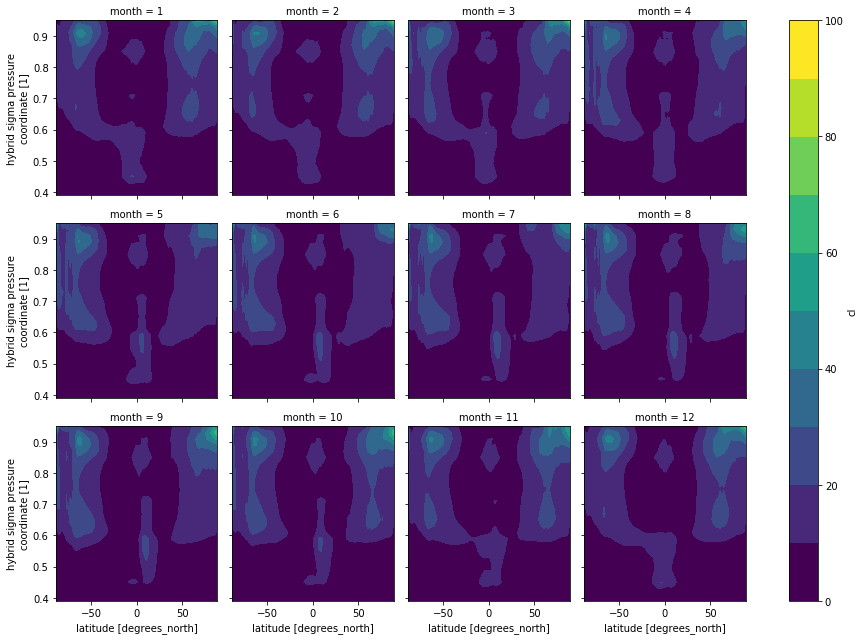

In [26]:
cl_mean.plot.contourf(levels=range(0,101,10), col='month', col_wrap=4)

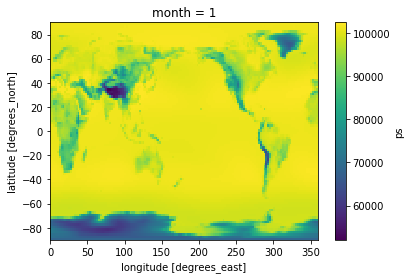

In [12]:
ds_mean[0].plot()

## Set up Dask Cluster

In [97]:
from dask.distributed import Client
from dask_kubernetes import KubeCluster
cluster = KubeCluster(n_workers=8)
client = Client(cluster)
cluster

## Construct Xarray Dataset by Crawling THREDDS Server

We are using NARR daily pressure-level data.

https://www.esrl.noaa.gov/psd/thredds/catalog/Datasets/NARR/Dailies/pressure/catalog.html

In [6]:
from siphon.catalog import TDSCatalog
cat_url = 'https://www.esrl.noaa.gov/psd/thredds/catalog/Datasets/NARR/Dailies/pressure/catalog.xml'
cat = TDSCatalog(cat_url)
dsets = [(cds.remote_access(use_xarray=True)
             .reset_coords(drop=True)
             .chunk({'time': 1, 'level': 5}))
         for cds in cat.datasets[:30]]
narr = xr.auto_combine(dsets)
narr

<xarray.Dataset>
Dimensions:            (level: 29, nbnds: 2, time: 912, x: 349, y: 277)
Coordinates:
  * level              (level) float32 1000.0 975.0 950.0 ... 150.0 125.0 100.0
  * y                  (y) float32 0.0 32463.0 64926.0 ... 8927325.0 8959788.0
  * x                  (x) float32 0.0 32463.0 64926.0 ... 11264660.0 11297120.0
  * time               (time) datetime64[ns] 1979-01-01 ... 1981-06-30
Dimensions without coordinates: nbnds
Data variables:
    Lambert_Conformal  (time) int32 -2147483647 -2147483647 ... -2147483647
    time_bnds          (time, nbnds) float64 dask.array<shape=(912, 2), chunksize=(1, 2)>
    air                (time, level, y, x) float32 dask.array<shape=(912, 29, 277, 349), chunksize=(1, 5, 277, 349)>

## Process Data in Parallel

This works amazingly well.

In [7]:
air_mean = narr.air[:100].mean(dim='time').load()

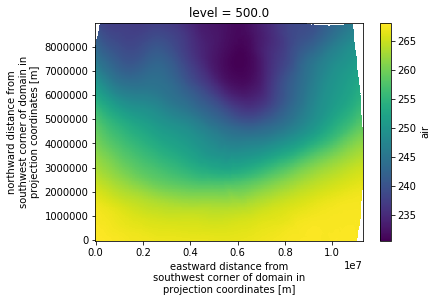

In [9]:
%matplotlib inline
air_mean.sel(level=500).plot()